# Credit Card Fraud Detection

---

## 1. Introduction
Credit card fraud detection is a classic problem in financial risk management.  
This project uses the Kaggle dataset (284,807 transactions, with only 492 fraud cases, ~0.17%),  
with the goal of building machine learning models to identify fraudulent transactions.

We will test three models:
- Logistic Regression
- Random Forest
- XGBoost

---

In [4]:
# Step 1. load the libraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb

## 2. Dataset Overview
- Dataset size: 284,807 rows × 31 columns  
- Features: `Time`, `Amount`, `V1` ~ `V28` (anonymized PCA features)  
- Target: `Class` (0 = normal transaction, 1 = fraud)

In [6]:
# Step 2. load the data
df = pd.read_csv("creditcard.csv")
print("Dataset size:", df.shape)
print(df["Class"].value_counts())
df.head()

Dataset size: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3. Exploratory Data Analysis (EDA)
We start by checking the class distribution.  
The dataset is highly imbalanced: only ~0.17% of the transactions are fraud.

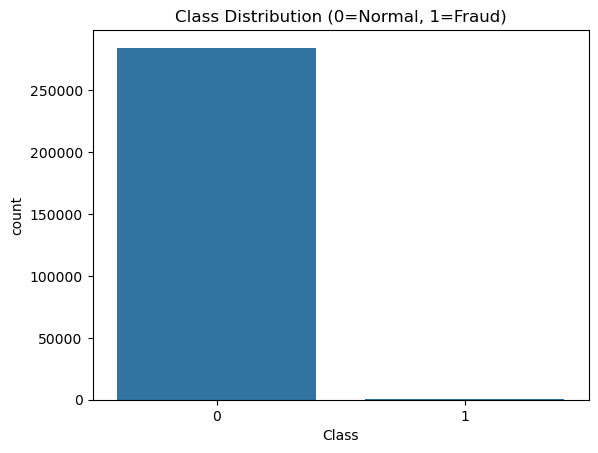

In [7]:
# Step 3: Class distribution
sns.countplot(x="Class", data=df)
plt.title("Class Distribution (0=Normal, 1=Fraud)")
plt.show()

## 4. Data Preprocessing
- Standardize `Time` and `Amount`  
- Split into training and test sets (70% / 30%)  
- Apply SMOTE oversampling on the training set to balance the classes

In [8]:
# Step 4: Data preprocessing

# featrures and labels
X = df.drop("Class", axis=1)
y = df["Class"]

# standardization
scaler = StandardScaler()
X[["Time", "Amount"]] = scaler.fit_transform(X[["Time", "Amount"]])

# split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# SMOTE for imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Training set after SMOTE:\n", y_train_res.value_counts())


Training set after SMOTE:
 Class
0    199020
1    199020
Name: count, dtype: int64


## 5. Modeling
We train and evaluate three models:
- Logistic Regression (baseline linear model)  
- Random Forest (bagging ensemble of decision trees)  
- XGBoost (gradient boosting decision trees)

In [9]:
# Step 5: Definite evaluate model

def evaluate_model(y_test, y_pred, y_prob, model_name):
    print(f"\n===== {model_name} =====")
    print(classification_report(y_test, y_pred, digits=4))
    print("AUC:", roc_auc_score(y_test, y_prob))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_test, y_prob):.4f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


===== Logistic Regression =====
              precision    recall  f1-score   support

           0     0.9998    0.9775    0.9885     85295
           1     0.0634    0.8784    0.1183       148

    accuracy                         0.9773     85443
   macro avg     0.5316    0.9279    0.5534     85443
weighted avg     0.9982    0.9773    0.9870     85443

AUC: 0.9659891030018235


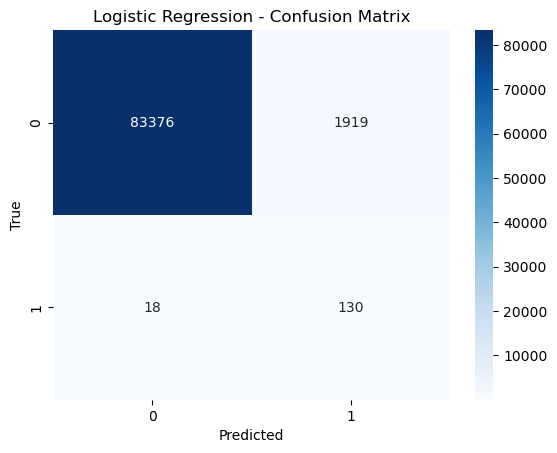

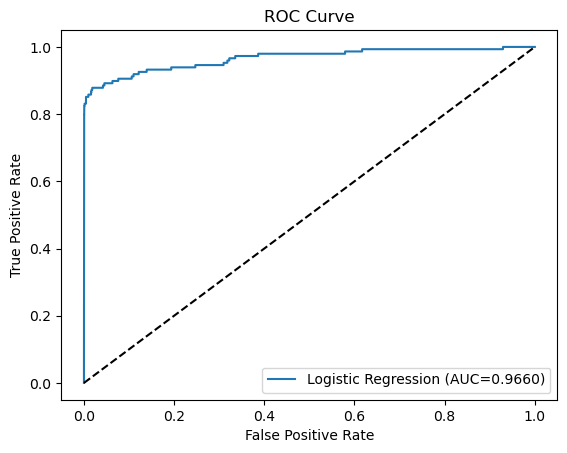

In [10]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_res, y_train_res)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")


===== Random Forest =====
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     85295
           1     0.8667    0.7905    0.8269       148

    accuracy                         0.9994     85443
   macro avg     0.9332    0.8952    0.9133     85443
weighted avg     0.9994    0.9994    0.9994     85443

AUC: 0.9544437587831104


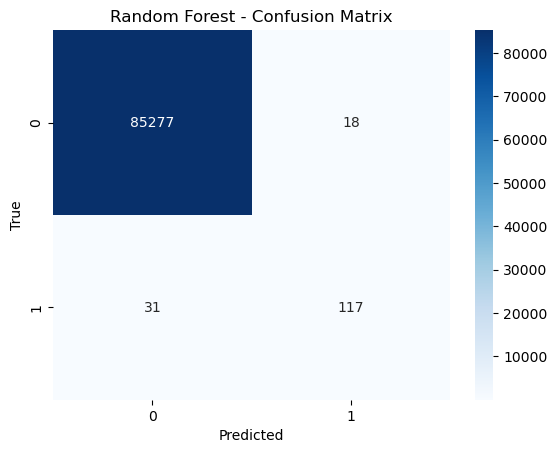

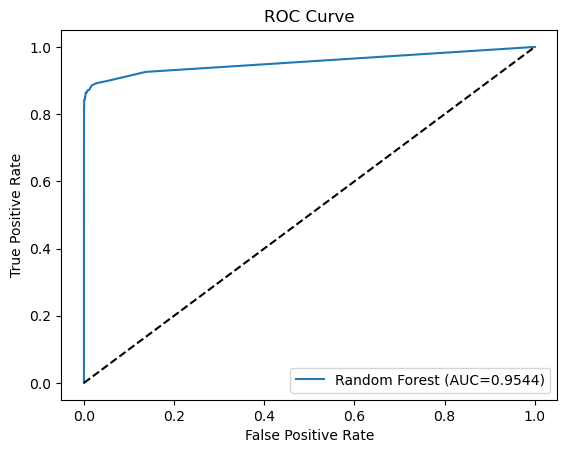

In [11]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")


===== XGBoost =====
              precision    recall  f1-score   support

           0     0.9997    0.9993    0.9995     85295
           1     0.6611    0.8041    0.7256       148

    accuracy                         0.9989     85443
   macro avg     0.8304    0.9017    0.8625     85443
weighted avg     0.9991    0.9989    0.9990     85443

AUC: 0.9758754592566656


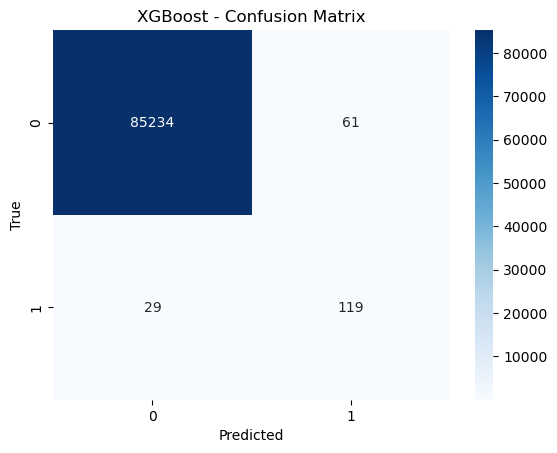

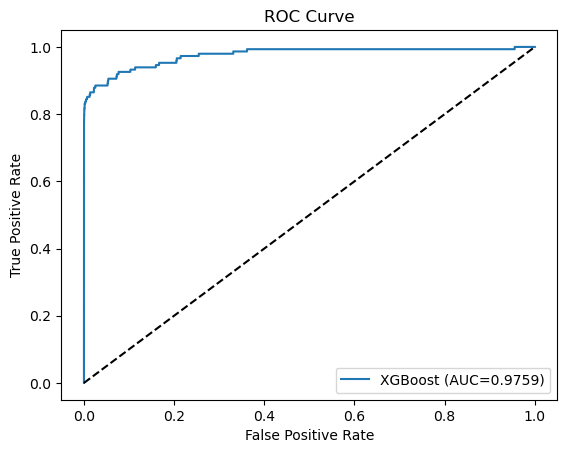

In [13]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1]),
    random_state=42,
    eval_metric="logloss"
)
xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_xgb, y_prob_xgb, "XGBoost")

## 6. Evaluation
For each model we report:
- Confusion matrix  
- Precision, Recall, F1-score  
- ROC curve and AUC  

Finally, we summarize the results in a comparison table.

In [15]:
# Step 6: Compare three models

from sklearn.metrics import precision_score, recall_score, f1_score

models = {
    "Logistic Regression": (y_test, y_pred_lr, y_prob_lr),
    "Random Forest": (y_test, y_pred_rf, y_prob_rf),
    "XGBoost": (y_test, y_pred_xgb, y_prob_xgb)
}

results = []
for name, (y_true, y_pred, y_prob) in models.items():
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    results.append([name, precision, recall, f1, auc])

# Create summary dataframe
results_df = pd.DataFrame(results, columns=["Model", "Precision", "Recall", "F1-score", "AUC"])
results_df

,Model,Precision,Recall,F1-score,AUC
0,Logistic Regression,0.063446,0.878378,0.118343,0.965989
1,Random Forest,0.866667,0.790541,0.826855,0.954444
2,XGBoost,0.661111,0.804054,0.725610,0.975875


## 7. Conclusion
- **Logistic Regression**: Very high Recall (88%), but very low Precision (6%) → catches most fraud but with many false positives.  
- **Random Forest**: High Precision (87%), Recall lower (79%) → fewer false positives, but misses some fraud.  
- **XGBoost**: Balanced Precision (66%) and Recall (80%), highest AUC (0.976) → best overall trade-off.  

📌 Practical implication:  
- If the goal is **catching as many frauds as possible** → prefer Recall-focused models (Logistic Regression / XGBoost).  
- If the goal is **reducing false alarms and manual review costs** → prefer Precision-focused models (Random Forest).  
- For balanced performance, **XGBoost is recommended**.  